# Transition Matrix Monte Carlo (TMMC)
[J. S. Wang and L. W. Lee, _Comp. Phys. Comm._ *127*, 131 (2000)](https://link.springer.com/article/10.1023/A:1013180330892)

This approach attempts to address two deficiencies of other multicanonical sampling methods that "visited states" approaches.

1. Information on sample distributions obtained during early MUCA or WL iterations with unrefined bias functions of density of states estimates is discarded and so (partially) wasted. 

2. Sample distributions obtained with visited stated methods are vulnerable to equilibration or "burn in", and can require long simulations such that the "traversal" time between the highest and lowest energies is very small compared to the total number of samples.

This is improved by making use of the transition matrix approach. In this context the transition matrix $T$ is a square matrix with number of rows/columns equal to the number of energy macrostates (bins) we wish to sample. Element $T_{ji}$ is the probability that our Metropolis MC algorithm (as in e.g. `Basic_MMC.ipynb`) will make a transition from bin $i$ to bin $j$. 

An estimate of $T$ can be updated by updating a "collection matrix" with the probability for attempting and rejecting every Monte Carlo move we make during sampling. We can similarly run biased MC as in `MUCA.ipynb`, refining the weights however we like. Provided we update the collection matrix using only the _unbiased_ acceptance probabilities we'll create a collection matrix from which the ubiased transition matrix can be constructed.

If we arrange the probabilities of obtaining a sample in each energy bin into a vector $\vec{P}$, then this is evolved by the transition matrix as;

$$ \vec{P}^{\prime} = T \vec{P} $$

where $\vec{P}^{\prime}$ is the evolved probabilities. By analagy with power iteration, repeatedly premultiplying $\vec{P}$ with $T$ will result in $\vec{P}^{\prime}$ = $\vec{P}$, i.e. the probability will evolve to an eigenvector of $T$ corresponding to the dominant eigenvalue. This is then the equilibrium probability distribution provided the trial moves used to construct $T$ obey detailed balance.

A multicanonical sampling procudure would then be:

1. Start running unbiased MC as in `Basic_MMC.ipynb`, adding to the collection matrix at every trial move using the _unbiased_ acceptance probabilities. 
2. Periodically use the collection matrix to estimate the transition matrix.
3. Diagonalise the transition matrix and find the current estimate of equililibrium probability.
4. Use this to construct MUCA bias $V(U)$ in the same way as in `MUCA.ipynb`
5. Add this bias into the MC sampling. 

Steps 2-4 are repeated until we have an unchanging set of weights and probability distribution $P(U)$ obtained from the dominant eigenvector of $T$. This can be reweighted to other temperatures as in basic MUCA case.

Note that at no point in the algorithm have we reset the collection matrix. Every MC move contributes from the first to the last. 

As an aside, a similar algorithm can be constructed for Wang-Landau sampling, where the dominant eigenvector of $T$ is the density of states in energy. I'll leave that as an exercise!

TMMC applied to basic multicanonical sampling is demonstrated below.

## Demonstration on our simple bead and spring "polymer" model

See `Basic_MMC.ipynb` and `polymer.py` for details of the model.

### Import packages and create some binning functions functions

In [1]:
from polymer import *
import numpy as np
import math as m
import matplotlib.pyplot as plt

In [2]:
def bin_index(x, bin_edges):
    """Given a list of bin_edges returned from numpy.histogram, and a sampled value x, 
       return the index of the bin in which x lies. Note that np.digitize is annoying
       and I don't like it.

    Parameters:
    x (float) : sample to assign to a bin
    bin_edges : bin edges as returned from numpy.histogram 

    Returns:
    i         : index of bin in which sample lies

    """
    
    bin_range = bin_edges[-1] - bin_edges[0]
    bin_pos = x - bin_edges[0]

    return int( (bin_pos/bin_range)*(len(bin_edges)-1.0) )

## Function to construct bias $V(U)$ from the current transition matrix

In [3]:
def bias_from_tm(tm, gutter, bin_edges, bin_width, temperature):
    """Given an collection matrix tm accumulated during a simulation at a particular temperature, 
       construct an estimate of the bias function needed to generated uniform sampling in 
       energy at that temperature.

    Parameters:
    tm                 : collection matrix (unnormalised transition matrix)
    bin_edges          : energy bin edges as returned from numpy.histogram 
    bin_width          : width of each energy bin (assumes all bins equal width)
    temperature        : temperature at which the collection matrix was 

    Returns:
    new_bias           : estimated bias function
    norm_tm            : the transition matrix
    statP              : equilibrium distribution for the current transition matrix

    """

    # Create transition matrix
    nstates = len(bin_edges)-1
    norm_tm = np.zeros([nstates,nstates])

    # Compute as appropriately normalised collection matrix
    for k in range(0, nstates):
        Pnorm = np.sum(tm[:,k]) + gutter[k]
        for kk in range(0, nstates):
            if Pnorm > 0.0:
                norm_tm[kk,k] = tm[kk,k]/Pnorm


    # Find the dominant eigenvector and store as statP
    eigvals, eigvects = np.linalg.eig(norm_tm)
    idom = np.argmax(np.real(eigvals))
    statP = np.absolute(eigvects[:,idom])

    # In case there are bins for which we have no data (yet)
    # replace zeros with minimum non-zero probability
    mincount = np.min(statP[statP > 0.0])
    statP = [ max(P,mincount) for P in statP]
    statP = statP/np.sum(statP)

    # Construct bias function needed for uniform energy sampling
    new_bias = np.zeros(nstates)
    for ibin, edge in enumerate(bin_edges[0:-1]):
        bin_energy = edge + 0.5*bin_width
        new_bias[ibin] = temperature*m.log(statP[ibin])

    # Shift bias so that minimum value is zero
    min_bias = np.min(new_bias)
    new_bias = [bias - min_bias for bias in new_bias]
    
    return new_bias, norm_tm, statP

### Function to implement TMMC for our polymer example

This requires only minimal changes from that in MUCA.ipynb

In [4]:
def run_tmmc_sweeps(chain, bin_edges, bias, trans_matrix, gutter, Nsweeps=100, max_disp=0.15, temperature=0.2, sample_int=100):
    """ Runs Nsweeps MC sweeps where one sweep is on average at attempt to move each mobile bead on the chain at least once.
        Returns a  """

    # Store inverse temperature
    beta = 1.0/temperature

    # Initialise sampling for the current set of sweeps
    samples = []
    acount  = 0

    # Establish total energy before any moves
    old_energy = chain.energy()
    
    for itrial in range(Nsweeps*(chain.Nbeads-1)):

        # Randomly choose any bead but the first
        ibead = np.random.randint(1,chain.Nbeads) # first bead never moves

        disp = 2.0*np.random.random_sample(2)-1.0
        disp = disp*max_disp
        
        # Make trial move and compute energy change - note we only compute the terms 
        # in the energy which depend on ibead. See polymer.py
        old_local_energy = chain.local_energy(ibead)
        chain.rpos[ibead] = chain.rpos[ibead] + disp
        new_local_energy = chain.local_energy(ibead)

        # Find bias energy V for old_energy U before move
        ibin = bin_index(old_energy, bin_edges)

        # Find bias energy V for new_energy U after move
        new_energy = old_energy + ( new_local_energy - old_local_energy )
        jbin = bin_index(new_energy, bin_edges)

        new_energy = old_energy + ( new_local_energy - old_local_energy )
        jbin = bin_index(new_energy, bin_edges)

        # (New for TMMC) probability of staying in the same bin, ignoring bias
        trans_matrix[ibin,ibin] += 1.0 - min(1.0, m.exp(-beta*(new_local_energy - old_local_energy)))

        # Only compute energy change if within limits where V is defined
        if jbin in range (0, len(bias)):


            # (New for TMMC) probability of moving to jbin, ignoring bias
            trans_matrix[jbin,ibin] += min(1.0, m.exp(-beta*(new_local_energy - old_local_energy)))

            # Add change in V into diff_energy
            old_bias = bias[ibin]
            new_bias = bias[jbin]         
            diff_energy = (new_energy + new_bias) - (old_energy + old_bias)
            
            # Accept or reject move
            if np.random.sample() < m.exp(-diff_energy*beta):
                # accepted
                acount = acount + 1.    # Accepted - increment counter
                old_energy = new_energy # (New for MUCA) update old_energy for next move
            else:
                # Restore original chain position 
                chain.rpos[ibead] = chain.rpos[ibead] - disp

        else:

            # (New for TMMC) Add the transition probability for leaving range of interest into gutter
            gutter[ibin] += min(1.0, m.exp(-beta*(new_local_energy - old_local_energy)))

            # reject and reset
            chain.rpos[ibead] = chain.rpos[ibead] - disp
        
        # Sample energy and end-to-end distance every sample_int sweeps
        if itrial%sample_int*(chain.Nbeads-1)==0:
            samples.append((chain.energy(), chain.end2end()))

        ratio = acount/(Nsweeps*(chain.Nbeads-1)) 
        
    # (Modified for TMMC) return trans_matrix as well as other quantities
    return chain, samples, trans_matrix, gutter, acount/(Nsweeps*(chain.Nbeads-1))    

### Setup a simulation which uses the above to iteratively refine V

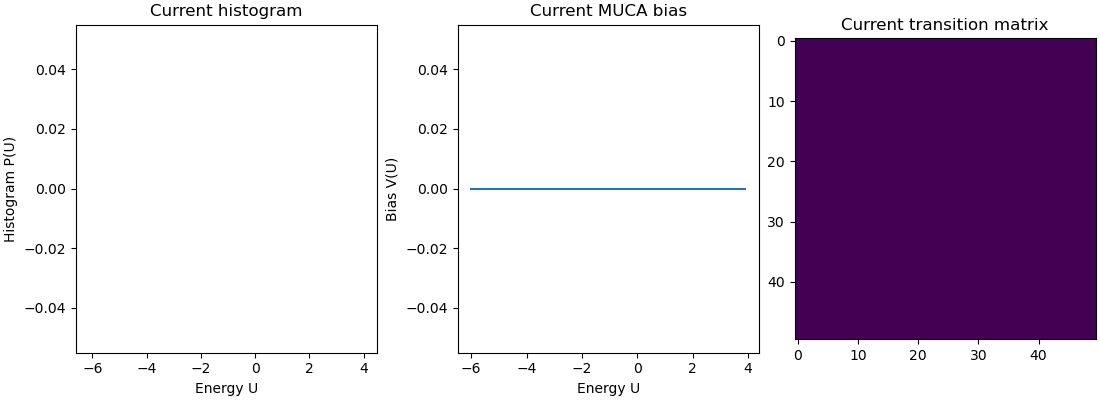

In [5]:
# Initialise TMMC simulation
Ndims=2 ; Nbeads=7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

# Create initial bias function, histogram and transition matrix, and TM eigenvalue
bias = np.zeros(len(bin_edges)-1)
histogram = np.zeros(len(bin_edges)-1)
trans_matrix = np.zeros([len(bin_edges)-1,len(bin_edges)-1]) ; gutter = np.zeros(len(bin_edges)-1)
norm_tm = np.copy(trans_matrix)
statP = np.zeros(len(bin_edges)-1)

# Setup some plots
%matplotlib widget

def label_tmmc_figure(fig, ax1, ax2, ax3):
    """ Sets up figures and axis for TMMC demonstration """

    ax1.set_xlabel('Energy U')
    ax2.set_xlabel('Energy U')
    ax1.set_ylabel('Histogram P(U)')
    ax2.set_ylabel('Bias V(U)')
    ax1.set_title('Current histogram')
    ax2.set_title('Current MUCA bias')
    ax3.set_title('Current transition matrix')

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(11, 4), constrained_layout=True)
label_tmmc_figure(fig, ax1, ax2, ax3)
ax1.bar(bin_edges[:-1], histogram,   width=bin_width,align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, bias)
ax3.imshow(trans_matrix)
plt.show()

In [6]:
from ipywidgets import IntProgress
from IPython.display import display
import time

temp = 0.4     # Temperature at which to sample
Ncycles=  5    # Bias update cycles
Nframes = 500  # Number frames per bias update cycle


# If starting from an existing bias function
#filename = 'data/muca_bias_N7T0.4_cycle_49.txt'
#bias = np.loadtxt(filename)
#initial_bias = np.copy(bias)

# Loop over updates of the weights
for icyc in range(Ncycles):

    # I like a progress bar
    f = IntProgress(min=0, max=Nframes)
    display(f) # display the bar

    # Initialise list of samples for current cycle
    samples = []

    # Zero current visited states histogram
    histogram = np.zeros(len(bin_edges)-1)

    fig.canvas.draw()
    fig.canvas.flush_events()

    for iframe in range(Nframes):

        chain, new_samples, trans_matrix, gutter, ratio = run_tmmc_sweeps(chain, bin_edges, bias, trans_matrix, gutter, max_disp=0.1, temperature=temp)
        samples += new_samples
        f.value +=1  # Increment progress bar

        energy_samples  = [ sample[0] for sample in samples ]
        counts, bins = np.histogram(energy_samples, bins=bin_edges, density=True)

        # Update plots
        ax1.cla(), ax2.cla(); ax3.cla()
        label_tmmc_figure(fig, ax1, ax2, ax3)
        ax1.bar(bin_edges[:-1], counts, width=bin_width,align='edge', label='Visited states')
        ax1.plot(bin_edges[:-1]-bin_width, statP/bin_width, 'r-', label='TM Eigenvector')
        ax2.plot(bin_edges[:-1]+0.5*bin_width, bias,'o-')
        #ax2.plot(bin_edges[:-1]+0.5*bin_width, initial_bias,'-')
        ax3.imshow(norm_tm)
        ax1.legend()
        plt.draw()
    
        fig.canvas.draw()
        fig.canvas.flush_events()


    print("Accepted ",round(ratio*100,2),"% of trial moves")
    
    # Compute new bias weights from transition matrix
    bias, norm_tm, statP = bias_from_tm(trans_matrix, gutter, bin_edges, bin_width, temp)


IntProgress(value=0, max=500)

Accepted  68.5 % of trial moves


IntProgress(value=0, max=500)

Accepted  32.83 % of trial moves


IntProgress(value=0, max=500)

Accepted  66.33 % of trial moves


IntProgress(value=0, max=500)

Accepted  74.83 % of trial moves


IntProgress(value=0, max=500)

Accepted  66.83 % of trial moves


## Histogram reweighting

As we've sampled the entire energy range of interest, we don't need to limit ourselves to a single temperature. If the MUCA simulation was performed at a temperature of $T_1$, inverse temperature $\beta_1=1/k_B T_1$ then we can reweight each entry in the transition matrix eigenvector with

$$ w_i = \exp{[(\beta_1 -\beta_2) U_i]}  $$

where $U_i$ is the mid-bin energy to obtain the histogram for inverse temperature $\beta_2$ and hence temperature $T_2 = 1/\beta_2$.  From this we can compute mean energy, heat capacity etc as before.

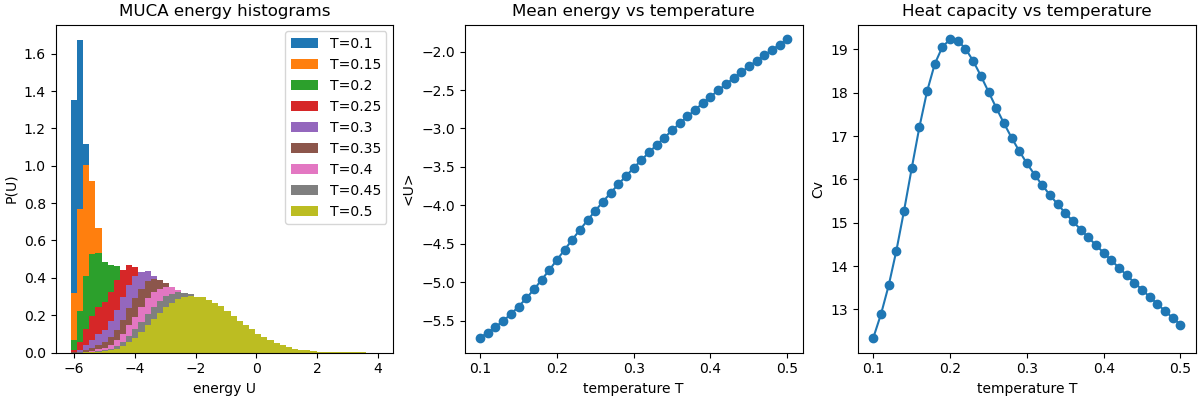

In [8]:
# Temperatures of interest - we can make this as fine as we like since each temperature no longer requires
# a new simulation to sample.
#temperatures = np.arange(0.1, 0.55, 0.05)
temperatures = np.arange(0.1, 0.51, 0.01)
orig_temp = 0.4
beta_o = 1.0/orig_temp

# Setup plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

ax1.set_xlabel('energy U')
ax1.set_ylabel('P(U)')
ax1.set_title("MUCA energy histograms")

ax2.set_xlabel('temperature T')
ax2.set_ylabel('<U>')
ax2.set_title('Mean energy vs temperature')  

ax3.set_xlabel('temperature T')
ax3.set_ylabel('Cv')
ax3.set_title('Heat capacity vs temperature') 

# Initialise arrays 
mean_energies   = np.zeros(len(temperatures))
mean_errors     = np.zeros(len(temperatures))
heat_caps       = np.zeros(len(temperatures))
#heat_caps2      = np.zeros(len(temperatures))

# Loop over temperatures of interest
for itemp, new_temp in enumerate(temperatures):

    beta_n = 1.0/new_temp

    # Reweighted histogram
    prob = np.zeros(len(bin_edges)-1)
    
    # Reweight histogram
    for ibin, edge in enumerate(bin_edges[:-1]):
        bin_energy = edge + 0.5*bin_width
        weight = m.exp((beta_o - beta_n)*bin_energy)
        prob[ibin] = statP[ibin]*weight

    # Normalise
    prob = prob/(np.sum(prob)*bin_width)

    # Only plot every 5th histogram to avoid crowding the axes
    if itemp%5 == 0:
        strlabel = "T={:1.2}".format(new_temp)
        ax1.bar(bin_edges[:-1], prob, width=bin_width, align='edge', label=strlabel)
    
    # Mean energy
    mean_energy = np.dot(bin_edges[:-1]+0.5*bin_width, prob)/np.sum(prob)
    mean_energies[itemp] = mean_energy

    # Compute heat capacity using the histogram
    msq_dev = np.zeros(len(bin_edges)-1)
    for ibin, edge in enumerate(bin_edges[:-1]):
        bin_energy = edge + 0.5*bin_width
        msq_dev[ibin] = (bin_energy - mean_energies[itemp])**2
        
    heat_caps[itemp] = np.dot(msq_dev, prob)*bin_width/(new_temp**2) + (Ndims/2)*(Nbeads-1)


# Complete plots using data computed above
ax1.legend()
ax2.errorbar(temperatures, mean_energies,yerr=mean_errors, fmt='-o')
ax3.plot(temperatures, heat_caps, '-o', label='samples')
plt.show()

## Sample reweighting

This is all fine provided the only quanities I want to know at any temperature can be computed directly from the energy histogram. Any other quantities need to sampled during a MUCA run with a fixed bias energy along with the corresponding microstate energy $U$ so that we can give them an appropriate weight at the new temperature and to remove the effect of the bias $V(U)$. 

This proceeds exactly as per the sample run with fixed weights in `MUCA.ipynb` only now the fixed weights used are those constructed from the transition matrix. We won't bother repeating that exercise here.